# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

In [2]:
# plot anneal offset ranges
#solver = "DW_2000Q_5"
#sampler = DWaveSampler(solver=solver)
#plot_anneal_offset(sampler)

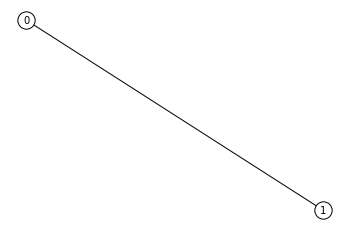

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'total_qubits': 4, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}
Greedy solution
 {0}
Solving 1/10FixEmbedding_NegBinary_-0.04_0.08
[-1.5 -1.5  1.   1. ]
[-0.04, -0.04, 0.04, 0.04]


KeyboardInterrupt: 

In [6]:
# Define Adjacency matrix
# graph, tag = gt.generate_nn_graph(v)
# graph, tag = gt.generate_hamming_graph(d, v)
# graph, tag = gt.generate_bipartite_graph(p, q)
# graph, tag = gt.generate_newman_watts_strogatz_graph(v, n, p)
# graph, tag = gt.generate_corona_graph(k, n)

# Define anneal offset
# "constant": no offset
# "linear": linear with respect to |h|

#for offsetx in [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]:
for offtype in ["negbinary", "constant", "binary"]:
    for nvertices in range(2, 19):
        """User defined inputs"""
        # Define graph
        #graph, tag = gt.generate_limited_corona_graph(2, 0)
        graph, tag = gt.generate_nn_graph(nvertices)
        penalty = 2
        # Embedding retries
        retries = 100000
        # Set functional form of anneal offset
        target_min = -0.04
        target_range = 0.08
        problem_min = -0.04
        problem_range = 0.08
        offsetcls = AnnealOffset(offtype)
        # DWave parameters
        annealing_time = 400  # integer microseconds [1, 2000] #OPTIMIZED
        answer_mode = "raw"  # histogram or raw
        auto_scale = True
        num_reads = 1000  # raw will dump out all results
        num_spin_reversal_transforms = 10 # OPTIMIZED
        readout_thermalization = 0  # default 0
        programming_thermalization = 1000  # default 1000
        # Iterate for more statistics
        iterations = 10
        insertdb = True

        """Start program"""
        # get qubo
        directed = False
        qubo = get_mds_qubo(
            graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
        )
        q_min = np.array(list(qubo.values())).min()

        # plot graph
        gt.get_plot(graph, directed=directed)
        plt.show()
        graph_params = graph_summary(tag, graph, qubo)
        print(graph_params)

        # greedy solution
        G = nx.Graph()
        G.add_edges_from(graph)
        print("Greedy solution\n", dominating_set(G))

        # convert to Ising
        J, h, C = QUBO_to_Ising(qubo.todense().tolist())
        maxJ = max(abs(J).flatten())
        maxh = max(abs(h))

        # Set chain strength
        chain_strength = maxJ * 2

        # DWave settings
        solver = "DW_2000Q_5"
        sampler = DWaveSampler(solver=solver)

        qpu_graph = sampler.edgelist
        qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}

        for idx in range(iterations):
            print(f"\rSolving {idx+1}/{iterations}", end="")
            embed, embedding, min_offset, max_offset = retry_embedding(
                sampler=sampler,
                qubo_dict=qubo_dict,
                qpu_graph=qpu_graph,
                graph_tag=tag,
                target_min=target_min,
                target_range=target_range,
                n_tries=retries,
            )
            anneal_offsets, exp_tag = find_offset(
                h=h,
                fcn=offsetcls.fcn,
                embedding=embedding,
                offset_min=problem_min,
                offset_range=problem_range,
            )
            dwave_config = {
                "annealing_time": annealing_time,  # integer microseconds [1, 2000]
                "answer_mode": answer_mode,  # histogram or raw
                "auto_scale": auto_scale,
                "num_reads": num_reads,  # raw will dump out all results
                "num_spin_reversal_transforms": num_spin_reversal_transforms,
                "readout_thermalization": readout_thermalization,  # default 0
                "programming_thermalization": programming_thermalization,  # default 1000
                "chain_strength": chain_strength,
                "anneal_offsets": anneal_offsets,
            }

            experiment_params = experiment_summary(
                machine=solver,
                settings=dwave_config,
                penalty=penalty,
                chain_strength=chain_strength,
                tag=exp_tag,
            )

            # Solve on DWave and push to database
            result = embed.sample_qubo(qubo_dict, **dwave_config)
            raw = result.to_pandas_dataframe()
            data_params = data_summary(raw, graph_params, experiment_params)
            if insertdb:
                result = insert_result(graph_params, experiment_params, data_params)
print("\nDONE")

In [4]:
raw.sort_values("energy", ascending=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,chain_break_fraction,energy,num_occurrences
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,-10.0,477
1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,-9.0,56
2,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0.0,-9.0,19
3,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0.0,-9.0,19
4,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0.0,-9.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0.0,-6.0,2
69,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0.0,-6.0,1
82,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,0.0,-6.0,1
74,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,-6.0,1
